# Kiva - mining loans with K-Means Clustering

Attempt to identify natural groups in the dataset of worldwide microfunding loans from Kiva (Microfunding organization). 

By identifying natural groups, we would be able to gain knowledge about the behaviour of new loans that fall into the same group.

Kiva Loans dataset is obtained from https://build.kiva.org/docs/data/snapshots.

General data about the countries is obtained from https://data.worldbank.org/


## Approach

1.Take samples from dataset

2.Scale and Encode samples

3.Apply Principal Component Analysis (Reduce dimensions)

4.Choose appropriate number of clusters using metrics

5.After choosing, apply K-Means to the samples (train/test) 

6.Explore the loans dataset with the identified cluster 
    (Get descriptions of the clusters)
    
7.Use K-Means model on new loans, return the predicted cluster 
    Also return it's descriptive statistics
    

In [6]:
import pandas as pd
import collections
import requests

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pickle



plt.style.use('seaborn')

In [7]:
loans_samples_reduced = pd.read_csv('final_reduced_dataset.csv')
loans_samples_reduced = loans_samples_reduced.set_index('loan_id')
loans_samples_reduced['borrower_count'] = loans_samples_reduced['female_count']+loans_samples_reduced['male_count']

In [8]:
# Shape of the cleaned dataset

print('Size of the cleaned dataframe',loans_samples_reduced.shape)

loans_samples_reduced.columns


Size of the cleaned dataframe (870520, 20)


Index(['loan_amount', 'status', 'activity_name', 'sector_name', 'country',
       'lender_term', 'num_lenders_total', 'num_journal_entries',
       'repayment_interval', 'female_count', 'male_count', 'shortage_fund',
       'posted_raised_hours', 'mpi', 'population_in_mpi', 'Education',
       'Health', 'Living standards', 'population_in_severe_mpi',
       'borrower_count'],
      dtype='object')

## Stratified Random Sampling by sectors

Sampling to reduce complexity and time taken by the process.

Stratified random sampling is advantageous when it can be used accurately because it ensures each subgroup within the population receives proper representation within the sample.


In [9]:
loans_samples = loans_samples_reduced.groupby(['sector_name'], group_keys=False).apply(lambda x: x.sample(min(len(x), 1500)))

loans_samples = loans_samples.reset_index(drop=True)

print('Size of the stratified sample dataframe',loans_samples.shape)

Size of the stratified sample dataframe (21563, 20)


In [10]:
def getFeatureVector(dataset):
    
    X = dataset[['loan_amount', 'status', 'activity_name', 'sector_name','borrower_count','mpi', 'population_in_mpi',
                 'Education', 'Health', 'Living standards', 'population_in_severe_mpi']]

    dataset_dummies = pd.get_dummies(X)

    scaler = StandardScaler()
    scaler.fit(dataset_dummies)

    data_scaled = scaler.transform(dataset_dummies)
    
    feature = pd.DataFrame(data_scaled)
    feature.columns = dataset_dummies.columns
    return feature

features_df = getFeatureVector(loans_samples)
features_df.head()

,loan_amount,borrower_count,mpi,population_in_mpi,Education,Health,Living standards,population_in_severe_mpi,status_funded,activity_name_Agriculture,...,sector_name_Entertainment,sector_name_Food,sector_name_Health,sector_name_Housing,sector_name_Manufacturing,sector_name_Personal Use,sector_name_Retail,sector_name_Services,sector_name_Transportation,sector_name_Wholesale
0,1.222901,-0.239488,-0.822307,-0.906308,0.854858,-0.095827,-0.715687,-0.602070,0.0,-0.096757,...,-0.220524,-0.273431,-0.273431,-0.273431,-0.273431,-0.273431,-0.273431,-0.273431,-0.273431,-0.227714
1,1.444492,-0.239488,0.342100,0.471563,-1.596396,0.099850,1.415120,-0.074001,0.0,-0.096757,...,-0.220524,-0.273431,-0.273431,-0.273431,-0.273431,-0.273431,-0.273431,-0.273431,-0.273431,-0.227714
2,-0.882211,-0.239488,-0.822307,-0.906308,0.854858,-0.095827,-0.715687,-0.602070,0.0,-0.096757,...,-0.220524,-0.273431,-0.273431,-0.273431,-0.273431,-0.273431,-0.273431,-0.273431,-0.273431,-0.227714
3,0.890515,-0.239488,-0.734757,-0.716097,-0.839705,-0.134963,0.938225,-0.772677,0.0,-0.096757,...,-0.220524,-0.273431,-0.273431,-0.273431,-0.273431,-0.273431,-0.273431,-0.273431,-0.273431,-0.227714
4,1.555287,1.783659,-0.340785,-0.298560,1.121299,-1.817786,0.816464,-0.382718,0.0,-0.096757,...,-0.220524,-0.273431,-0.273431,-0.273431,-0.273431,-0.273431,-0.273431,-0.273431,-0.273431,-0.227714


In [11]:
def applyPCA(n,features):
    pca = PCA(n_components=n) 
    principal_df = pd.DataFrame(pca.fit_transform(features))
    PCA_stats = pd.DataFrame(pca.components_,columns=features.columns,index = range(0,n)).transpose()
    print(f"PCA transformation applied with {n} components:")
    print("\nTop 5 features in each principal component")
    print([PCA_stats[c].nlargest(5) for c in PCA_stats])
    print('-----------------------------------------------')
    
    return principal_df

applyPCA(3,features_df)

print('')

PCA transformation applied with 3 components:

Top 5 features in each principal component
[population_in_mpi           0.491097
mpi                         0.487333
population_in_severe_mpi    0.460009
Living standards            0.268839
borrower_count              0.140529
Name: 0, dtype: float64, sector_name_Personal Use         0.408491
activity_name_Home Appliances    0.348830
Education                        0.292172
borrower_count                   0.197323
sector_name_Retail               0.168823
Name: 1, dtype: float64, sector_name_Personal Use         0.397641
activity_name_Home Appliances    0.323329
borrower_count                   0.228788
sector_name_Agriculture          0.188052
Health                           0.181400
Name: 2, dtype: float64]
-----------------------------------------------



In [12]:
# Assuming 3 components on PCA - plot the clusters

def plotClusters(n,transformed):
    
    colors = ['#2f7ed8', '#0d233a', '#8bbc21', '#910000', '#1aadce', '#492970', '#f28f43', '#77a1e5', '#c42525', '#a6c96a']
    
    for i in range(n): 
        
        plt.title('View in pair of 2 Dimensions')
        
        ax = plt.subplot(1,3,1)
        ax.scatter(transformed[transformed['y']==i][0],  
                   transformed[transformed['y']==i][1],  
                   label=f'Class {i}', 
                   c=colors[i])
        ax = plt.subplot(1,3,2)
        ax.scatter(transformed[transformed['y']==i][1],  
                   transformed[transformed['y']==i][2],  
                   label=f'Class {i}', 
                   c=colors[i])
        ax = plt.subplot(1,3,3)
        ax.scatter(transformed[transformed['y']==i][0],  
                   transformed[transformed['y']==i][2],  
                   label=f'Class {i}', 
                   c=colors[i])
   
    plt.savefig('image/ViewClusters_2D.png')
    fig = plt.figure(figsize=(8,8))
    ax = p3.Axes3D(fig)
    
    for i in range(n):
        ax.scatter(transformed[transformed['y']==i][0],  
                   transformed[transformed['y']==i][2], 
                   transformed[transformed['y']==i][1],  
                   label=f'Class {i}', 
                   c=colors[i])
    
    plt.legend()
    plt.title('View in 3 Dimensions')
    plt.savefig('image/ViewClusters_3D.png')
    


In [13]:
# Sticking with 3 component PCA to help visualize the clusters

pca_transformed = applyPCA(3,features_df)

all_cluster_stats = pd.DataFrame()    

PCA transformation applied with 3 components:

Top 5 features in each principal component
[population_in_mpi           0.491661
mpi                         0.487997
population_in_severe_mpi    0.460883
Living standards            0.268310
borrower_count              0.140478
Name: 0, dtype: float64, sector_name_Personal Use         0.368802
activity_name_Home Appliances    0.316085
Education                        0.303745
borrower_count                   0.172408
sector_name_Housing              0.151561
Name: 1, dtype: float64, sector_name_Personal Use                   0.448723
activity_name_Home Appliances              0.370161
borrower_count                             0.260195
sector_name_Health                         0.225403
activity_name_Personal Medical Expenses    0.178052
Name: 2, dtype: float64]
-----------------------------------------------


## Choosing K

Main idea is to make sure points are much closer to the ones in same cluster, than the points in other clusters. This seems to assure that the clusters are distinctive.

The_silhouette_method  - https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set

Inertia/Intra cluster distance - https://www.datascience.com/blog/k-means-clustering

In [14]:
k_silhouette_scores = []

k_interia_scores = []

for k in range(2,10):
    
    kmeans = KMeans(n_clusters=k, random_state=0).fit(pca_transformed)

    label = kmeans.labels_

    print(f"\nCluster sizes of {k} clusters: \n\t {collections.Counter(label)}")
   
    silhouette_avg = silhouette_score(pca_transformed, label)
    inertia_value = (kmeans.inertia_/k)
    
    k_silhouette_scores.append(silhouette_avg)
    k_interia_scores.append(inertia_value)
    
    print("\nThe average silhouette_score is :", silhouette_avg,
          "\nThe mean intra cluster distance is :", inertia_value)



Cluster sizes of 2 clusters: 
	 Counter({1: 11674, 0: 9889})

The average silhouette_score is : 0.3219317637022528 
The mean intra cluster distance is : 62709.285806921565

Cluster sizes of 3 clusters: 
	 Counter({2: 11597, 1: 8411, 0: 1555})

The average silhouette_score is : 0.38689628083882266 
The mean intra cluster distance is : 28020.14490558163

Cluster sizes of 4 clusters: 
	 Counter({0: 9050, 1: 7441, 3: 3519, 2: 1553})

The average silhouette_score is : 0.42277677030247013 
The mean intra cluster distance is : 13855.728083942358

Cluster sizes of 5 clusters: 
	 Counter({3: 7439, 1: 6992, 4: 2858, 0: 2730, 2: 1544})

The average silhouette_score is : 0.3908121268523772 
The mean intra cluster distance is : 8952.229550248296

Cluster sizes of 6 clusters: 
	 Counter({0: 7130, 1: 4577, 5: 3477, 3: 2629, 4: 2209, 2: 1541})

The average silhouette_score is : 0.38811566659335967 
The mean intra cluster distance is : 6205.599858216843

Cluster sizes of 7 clusters: 
	 Counter({6: 500

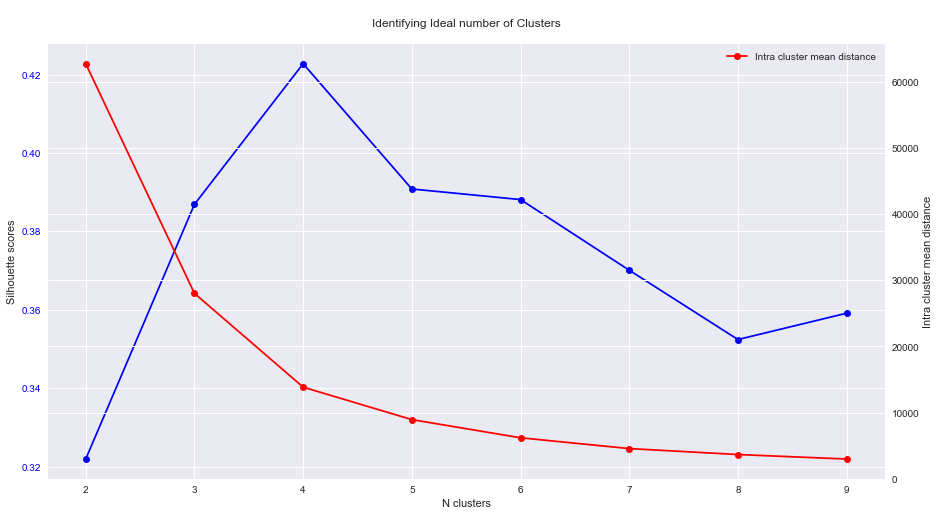

In [15]:
plt.figure(figsize=(15, 8))
ax1 = plt.subplot(1, 1, 1)
ax1.plot(range(2,10),k_silhouette_scores,marker='o',color='blue', label='Silhouette scores')
ax1.set_xlabel('N clusters')
ax1.set_ylabel('Silhouette scores')
ax1.tick_params('y', colors='b')
ax2 = ax1.twinx()
ax2.plot(range(2,10),k_interia_scores,marker='o',color='red', label='Intra cluster mean distance')
ax2.set_ylabel('Intra cluster mean distance', )
plt.title('\nIdentifying Ideal number of Clusters\n')
plt.savefig('image/Identifying_optimal_K.png')
plt.legend()
plt.show()


## Optimal K value 
#### Number - 4 
![title](img/Identifying_optimal_K.png)

In [16]:
n_clusters = 4

PCA transformation applied with 3 components:

Top 5 features in each principal component
[population_in_mpi           0.490448
mpi                         0.486656
population_in_severe_mpi    0.459170
Living standards            0.270308
borrower_count              0.140659
Name: 0, dtype: float64, sector_name_Personal Use         0.359007
Education                        0.308847
activity_name_Home Appliances    0.307275
borrower_count                   0.164351
sector_name_Retail               0.151121
Name: 1, dtype: float64, sector_name_Personal Use         0.451210
activity_name_Home Appliances    0.372058
borrower_count                   0.268898
sector_name_Agriculture          0.206764
activity_name_Home Energy        0.171002
Name: 2, dtype: float64]
-----------------------------------------------
PCA transformation applied with 3 components:

Top 5 features in each principal component
[population_in_mpi           0.492292
mpi                         0.488903
population_in_se

c:\users\ssank\anaconda3\envs\myflaskapp\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)




Test Sample


c:\users\ssank\anaconda3\envs\myflaskapp\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\ssank\anaconda3\envs\myflaskapp\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


NameError: name 'plot_categorical' is not defined

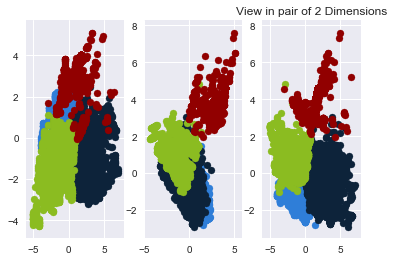

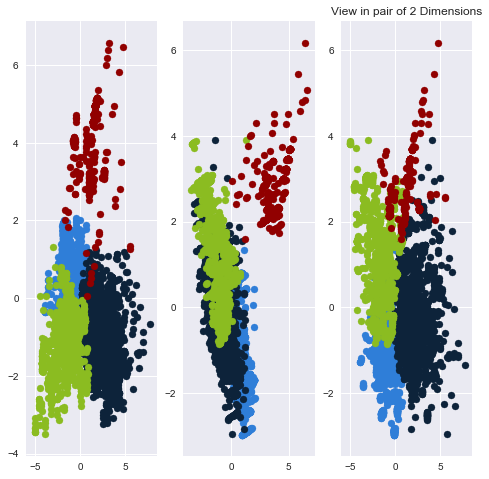

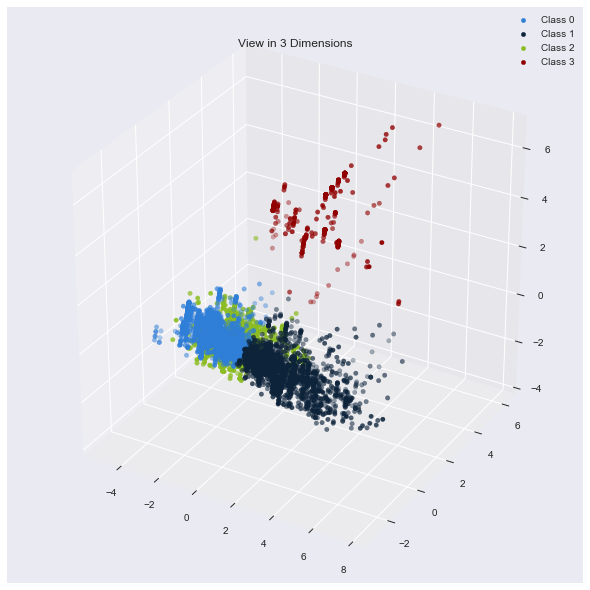

In [17]:
# Sticking with 3 component PCA to help visualize the clusters

def applyKMeansClustering(k,loan_samples):
    
    train_samples, test_samples = train_test_split(loans_samples,random_state=30)
    train_featured = getFeatureVector(train_samples)
    test_featured = getFeatureVector(test_samples)

    pca_transformed_train = applyPCA(3,train_featured)
    pca_transformed_test = applyPCA(3,test_featured)

    pca_clustered_train = pca_transformed_train
    pca_clustered_test = pca_transformed_test

    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(pca_transformed_train)

    label = kmeans.labels_
    predicted = kmeans.predict(pca_transformed_test)
    
    pca_clustered_train['y'] = label
    pca_clustered_test['y'] = predicted
    print('\nTraining Sample')
    plotClusters(k,pca_clustered_train)
    
    print('\n\nTest Sample')
    plotClusters(k,pca_clustered_test)

    train_samples_clustered = train_samples
    test_samples_clustered = test_samples
    
    train_samples_clustered['class'] = label
    test_samples_clustered['class'] =  predicted
    
    plot_categorical("train",train_samples_clustered) 
    plot_categorical("test",test_samples_clustered)
    plot_numerical("train",train_samples_clustered)
    plot_numerical("test",test_samples_clustered)
    
    list_pickle_path = f'Kiva_{k}_Clusters.pkl'
    list_pickle = open(list_pickle_path, 'wb')

    pickle.dump(kmeans, list_pickle)
    list_pickle.close()
    
    return train_samples_clustered.append(test_samples_clustered)


loan_samples_clustered = applyKMeansClustering(n_clusters,loans_samples) 

loan_samples_clustered.to_csv('Clustered_samples_dataset.csv')

## Applying K-Means

#### 2D views of clusters (3 dimensions) - Train/Test

Training | Test
- | - 
![alt](img/2D_training_clusters.png) | ![alt](img/2D_test_clusters.png)

# Applying K-Means

## 3D views of clusters - Train/Test

Training | Test
- | - 
![alt](img/Training_3D.png) | ![alt](img/Test_3D.png)

#### Top Countries in different clusters

![title](img/country_0.png)
![title](img/country_1.png)
![title](img/country_2.png)
![title](img/country_3.png)

#### Top Sectors in different clusters

![title](img/sector_0.png)
![title](img/sector_1.png)
![title](img/sector_2.png)
![title](img/sector_3.png)

#### Loan Amount

![title](img/train_numerical_loan_amount.png)

#### Number of lenders

![title](img/train_numerical_num_lenders_total.png)

#### Population in poverty (Multidimensional Poverty Index)

![title](img/train_numerical_population_in_mpi.png)

### Applying Model to New Loans

In [30]:
# Get Latest Loans from Kiva website - 'http://api.kivaws.org/v1/loans/newest.json'

getLatestLoans().head()


c:\users\ssank\anaconda3\envs\myflaskapp\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,activity_name,borrower_count,country,loan_amount,sector_name,status,mpi,population_in_mpi,Education,Health,Living standards,population_in_severe_mpi
0,Embroidery,1,pakistan,500,Arts,fundraising,0.237,45.6,36.2,32.3,31.6,26.5
1,Embroidery,1,pakistan,350,Arts,fundraising,0.237,45.6,36.2,32.3,31.6,26.5
2,Sewing,1,pakistan,450,Services,fundraising,0.237,45.6,36.2,32.3,31.6,26.5
3,Embroidery,1,pakistan,175,Arts,fundraising,0.237,45.6,36.2,32.3,31.6,26.5
4,Embroidery,1,pakistan,450,Arts,fundraising,0.237,45.6,36.2,32.3,31.6,26.5


#### Prediction - New Loans - Sample # 1
![alt](img/prediction_1.png) 

#### Prediction - New Loans Sample # 2

![alt](img/prediction_2.png)

## Next Steps

1. Deeper look into Lenders, Field partners etc.

2. Apply other clustering techniques and compare results




In [29]:
def getLatestLoans():
    response = requests.get('http://api.kivaws.org/v1/loans/newest.json').json()
    loan_items = response['loans']

    new_loans_dictionary = []

    for loan in loan_items:
        new_item = {
            'loan_amount': loan['loan_amount'],
            'status': loan['status'],
            'activity_name': loan['activity'],
            'sector_name': loan['sector'],
            'borrower_count': loan['borrower_count'],
            'country_name': loan['location']['country'].lower()
        }

        new_loans_dictionary.append(new_item)

    new_loans_df = pd.DataFrame(new_loans_dictionary)

    new_loans_df = new_loans_df.rename(columns={'country_name':'country'})

    mpi = pd.read_csv('mpi.csv',encoding='latin-1')

    mpi_reduced = mpi[['country','mpi','population_in_mpi','Education','Health','Living standards','population_in_severe_mpi']]
    mpi_reduced.to_csv('mpi.csv',encoding='utf-8')
    
    mpi_reduced.loc[:,'country'] = mpi_reduced['country'].apply(lambda x:x.lower())

    merged = new_loans_df.merge(mpi_reduced,on='country')

    return merged

In [40]:
def plot_numerical(heading,df):
    for c in ['loan_amount','female_count', 'male_count','population_in_mpi',
              'lender_term', 'num_lenders_total', 'posted_raised_hours','num_journal_entries']:

        plt.figure(figsize=(15,10))
        sns.boxplot(x="class", y=c, data=df, palette="Paired")
        plt.title(f'Cluster differences of {c}')
        plt.savefig(f'image/{heading}_numerical_{c}.png')
    
    stats = pd.DataFrame()

In [34]:
def describe_numerical(df):
    stats = pd.DataFrame()
        
    for k in range(n_clusters):  

        kth_cluster = df[df['class']==k]
        
        kth_stats = df[['loan_amount','female_count', 
                          'male_count','population_in_mpi',
                          'lender_term', 'num_lenders_total', 
                          'posted_raised_hours','num_journal_entries'
                       ]].describe().transpose()
        
    stats = stats.append(kth_stats)   
        
    return stats[['mean','50%']]

In [35]:
def describe_categorical(df):

    cluster_frequency = []

    for k in range(n_clusters):
        kth_cluster = df[df['class']==k]

        category_values = {
            str(k) : {}
        }

        for c in ['country','sector_name','activity_name','status']:
            cat_values = kth_cluster[c].value_counts().head(10).to_dict()
            category_values[str(k)].update({str(c):cat_values})

        cluster_frequency.append(category_values)
        
    return cluster_frequency

In [46]:
describe_numerical(loan_samples_clustered)

,mean,50%
loan_amount,425.395353,400.0
female_count,0.927793,1.0
male_count,0.308862,0.0
population_in_mpi,26.099096,19.4
lender_term,12.599082,12.0
num_lenders_total,13.217317,12.0
posted_raised_hours,238.805083,149.0
num_journal_entries,1.481705,1.0


In [45]:
describe_categorical(loan_samples_clustered)

[{'0': {'country': {'Philippines': 4337,
    'Peru': 1284,
    'Nicaragua': 827,
    'Colombia': 510,
    'Cambodia': 493,
    'Mexico': 305,
    'Kenya': 233,
    'Indonesia': 220,
    'Ecuador': 148,
    'Ghana': 136},
   'sector_name': {'Housing': 1236,
    'Retail': 1067,
    'Transportation': 1048,
    'Food': 920,
    'Manufacturing': 847,
    'Construction': 787,
    'Arts': 785,
    'Agriculture': 756,
    'Entertainment': 727,
    'Services': 495},
   'activity_name': {'Personal Housing Expenses': 1160,
    'General Store': 687,
    'Motorcycle Transport': 616,
    'Manufacturing': 373,
    'Crafts': 368,
    'Furniture Making': 350,
    'Games': 311,
    'Construction': 278,
    'Pigs': 269,
    'Farming': 266},
   'status': {'funded': 9139}}},
 {'1': {'country': {'Kenya': 2024,
    'Pakistan': 1571,
    'Uganda': 831,
    'India': 413,
    'Cambodia': 373,
    'Nigeria': 344,
    'Sierra Leone': 231,
    'Mozambique': 219,
    'Rwanda': 214,
    'Togo': 194},
   'sector_name

In [41]:
def plot_categorical(heading,df):

    for k in range(n_clusters):
        kth_cluster = df[df['class']==k]

        for c in ['country','sector_name','activity_name','status']:
            plt.figure(figsize=(20,5))
            cat_values = kth_cluster[c].value_counts().head(10).to_dict()
            kth_cluster[c].value_counts().head(10).plot(kind='barh')        
            plt.title(f'Cluster number: {k} - Top 10 in {c}')
            plt.savefig(f'image/{heading}_category_{c}.png')
